In [1]:
# !pip install einops

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio


if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:
img = torchvision.io.read_image("dog.jpg")
# img = torchvision.io.read_image("frog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


In [4]:
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([1365, 2048])


<ipython-input-4-88fb0e919f56>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


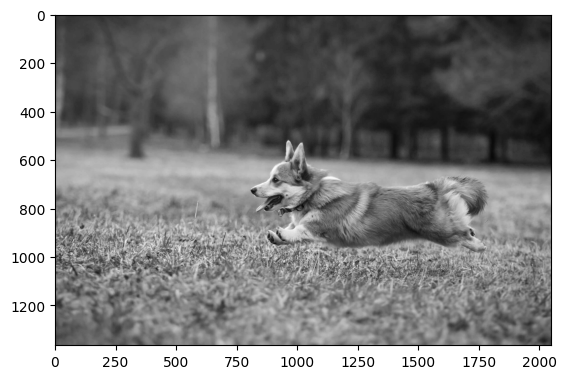

In [5]:
plt.imshow(img, cmap='gray')


In [6]:
cropImg = torchvision.transforms.functional.crop(img, 600, 800, 250, 250)
# cropImg = torchvision.transforms.functional.cropImg(img, 220, 1100, 300, 300)
cropImg.shape

torch.Size([250, 250])

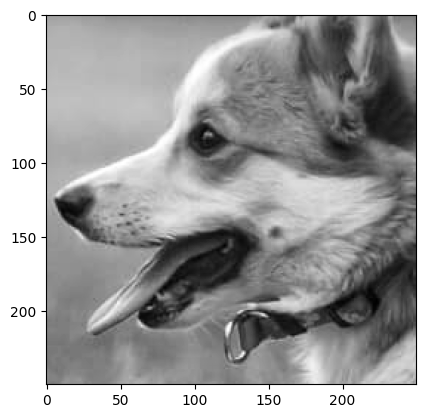

In [7]:
plt.imshow(cropImg, cmap='gray')

In [8]:
# Introduce missing pixels
# def introduce_missing_pixels(img, num_missing=900):
#     # Get the total number of elements in the image
#     total_pixels = img.numel()
#     # Generate random indices for missing pixels
#     indices = np.random.choice(total_pixels, num_missing, replace=False)
#     # Create a copy of the image to avoid modifying the original
#     flat_img = img.flatten()
#     flat_img[indices] = np.nan  # Set selected pixels to NaN
#     return flat_img.reshape(img.shape)


def introduce_missing_pixels(img, block_size=30):
    # Ensure the image is large enough to accommodate the block
    h, w = img.shape[-2], img.shape[-1]

    if block_size > min(h, w):
        raise ValueError("Block size is larger than the image dimensions")

    # Randomly choose the top-left corner for the missing block
    top_left_x = np.random.randint(0, h - block_size)
    top_left_y = np.random.randint(0, w - block_size)

    # Set the 30x30 block to NaN
    img_with_missing_block = img.clone()  # To avoid modifying the original image
    img_with_missing_block[top_left_x:top_left_x + block_size, top_left_y:top_left_y + block_size] = float('nan')

    return img_with_missing_block


In [9]:
# print(cropImg.numel())

In [10]:
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

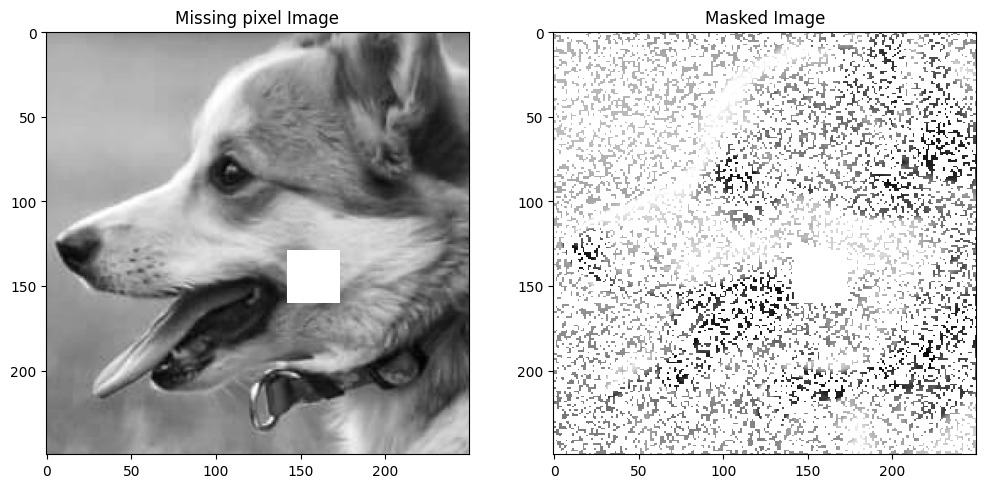

In [11]:

# Generate a sample image
original_img = cropImg

# Introduce missing pixels
missing_img = introduce_missing_pixels(original_img)


masked_img = mask_image(missing_img, 0.3)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(missing_img, cmap='gray')
plt.title('Missing pixel Image')

plt.subplot(1, 2, 2)
plt.imshow(masked_img[0], cmap='gray')
plt.title('Masked Image')

plt.show()

In [12]:
# print(masked_img.shape)

In [13]:


# Factorization function
def factorize(A, k, device=torch.device("cpu")):
    # A = torch.tensor(A, dtype=torch.float).to(device)
    A = A.to(device)

    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)

    for _ in range(1000):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return W, H


In [14]:
# Reconstruct using matrix factorization
W, H = factorize(masked_img[0], k=50)

FactReconstImg = torch.mm(W, H).cpu().detach()

Text(0.5, 1.0, 'Reconstructed Image')

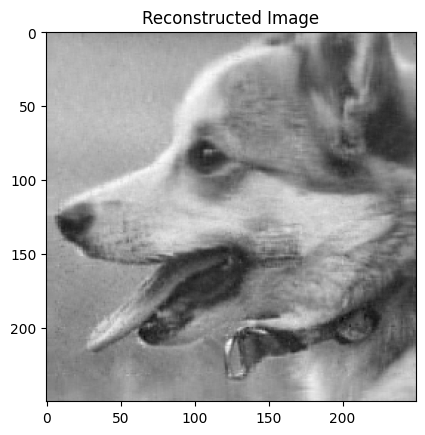

In [15]:
plt.imshow(FactReconstImg.numpy(), cmap='gray')
plt.title("Reconstructed Image")

In [18]:
# # Function to compute the RMSE
# def compute_rmse(original, reconstructed):
#     return np.sqrt(mean_squared_error(original, reconstructed))

# # Function to compute PSNR
# def compute_psnr(original, reconstructed):
#     return peak_signal_noise_ratio(original, reconstructed)

import torch
import torch.nn.functional as F

# Function to compute RMSE (Root Mean Squared Error) for PyTorch tensors
def compute_rmse(original, reconstructed):
    mse = F.mse_loss(reconstructed, original)
    rmse = torch.sqrt(mse)
    return rmse.item()

# Function to compute PSNR (Peak Signal-to-Noise Ratio) for PyTorch tensors
def compute_psnr(original, reconstructed):
    mse = F.mse_loss(reconstructed, original)
    if mse == 0:
        return float('inf')  # If there is no difference, PSNR is infinite
    max_pixel_value = 1.0  # Assuming the images are normalized between 0 and 1
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

In [21]:
rmse_mf = compute_rmse(original_img, FactReconstImg)
psnr_mf = compute_psnr(original_img, FactReconstImg)

print(f"Matrix Factorization RMSE: {rmse_mf} and PSNR: {psnr_mf}")

Matrix Factorization RMSE: 8.298166275024414 and PSNR: -18.379642486572266


In [ ]:
# class LinearModel(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(LinearModel, self).__init__()
#         self.linear = nn.Linear(in_features, out_features)

#     def forward(self, x):
#         return self.linear(x)

# def create_rff_features(X, num_features, sigma, batch_size=2000):
#     """
#     Transform the input data X using RBFSampler in batches and move the result to GPU.

#     Args:
#     - X (torch.Tensor): Input data of shape (num_samples, num_features)
#     - num_features (int): Number of features for RBFSampler
#     - sigma (float): Parameter for the RBF kernel
#     - batch_size (int): Size of the batch for processing

#     Returns:
#     - torch.Tensor: Transformed data on GPU
#     """
#     from sklearn.kernel_approximation import RBFSampler
#     rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))

#     X = X.cpu().numpy().astype(np.float16)  # Use float16 to reduce memory usage

#     num_batches = (X.shape[0] + batch_size - 1) // batch_size
#     all_transformed_batches = []

#     for i in range(num_batches):
#         # Calculate batch indices
#         start_idx = i * batch_size
#         end_idx = min((i + 1) * batch_size, X.shape[0])
#         batch_X = X[start_idx:end_idx]

#         # Fit the RBFSampler on the first batch
#         if i == 0:
#             rff.fit(batch_X)

#         # Transform the current batch
#         transformed_batch = rff.transform(batch_X)

#         # Convert the transformed batch to PyTorch tensor and move to GPU
#         transformed_tensor = torch.tensor(transformed_batch, dtype=torch.float32).to(device)

#         # Append to list of batches
#         all_transformed_batches.append(transformed_tensor)

#     # Concatenate all transformed batches on GPU
#     X_transformed = torch.cat(all_transformed_batches, dim=0)

#     return X_transformed

# # Reconstruct image using RFF and Linear Regression
# def reconstruct_with_rff(original_img, missing_img, num_features=100):
#     # Prepare input data
#     indices = np.argwhere(~np.isnan(missing_img))
#     X = indices
#     y = original_img[~np.isnan(missing_img)]

#     # Generate Random Fourier Features
#     rff = np.random.randn(X.shape[1], num_features)
#     X_rff = np.cos(np.dot(X, rff))

#     # Fit Linear Regression
#     model = LinearModel()
#     model.fit(X_rff, y)

#     # Reconstruct missing pixels
#     all_indices = np.argwhere(np.ones(original_img.size).astype(bool))
#     X_all_rff = np.cos(np.dot(all_indices, rff))
#     reconstructed = model.predict(X_all_rff)

#     img_reconstructed = np.full(original_img.shape, np.nan)
#     img_reconstructed[~np.isnan(missing_img)] = y
#     img_reconstructed[np.isnan(missing_img)] = reconstructed[np.isnan(missing_img)]

#     return img_reconstructed


## Using Random Fourier Features (RFF) and Linear Regression

In [22]:

from einops import rearrange

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width, dtype=torch.float16).repeat(height, 1)
    h_coords = torch.arange(height, dtype=torch.float16).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'h w -> (h w)').to(torch.float32)
    return X, Y

In [24]:
masked_img[0].shape

torch.Size([250, 250])

In [25]:
Img_X, Img_Y = create_coordinate_map(masked_img[0])

mask = ~torch.isnan(Img_Y)
Img_Y_clean = Img_Y[mask]

Img_X.shape, Img_Y.shape


(torch.Size([62500, 2]), torch.Size([62500]))

In [26]:
Img_Y

tensor([     nan,      nan, 164.6667,  ..., 177.0000,      nan, 177.6667])

In [27]:
# MinMaxScaler from -1 to 1
from sklearn import preprocessing

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Img_X.cpu())

# Scale the X coordinates
Img_X_scaled = scaler_X.transform(Img_X.cpu())

# Move the scaled X coordinates to the GPU
Img_X_scaled = torch.tensor(Img_X_scaled).to(device)

# Set to dtype float32
Img_X_scaled = Img_X_scaled.float()

In [28]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [29]:
# # create RFF features
# def create_rff_features(X, num_features, sigma):
#     from sklearn.kernel_approximation import RBFSampler
#     rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
#     X = X.cpu().numpy()
#     X = rff.fit_transform(X)
#     return torch.tensor(X, dtype=torch.float32).to(device)

In [30]:
def create_rff_features(X, num_features, sigma, batch_size=3000):
    """
    Transform the input data X using RBFSampler in batches and move the result to GPU.

    Args:
    - X (torch.Tensor): Input data of shape (num_samples, num_features)
    - num_features (int): Number of features for RBFSampler
    - sigma (float): Parameter for the RBF kernel
    - batch_size (int): Size of the batch for processing

    Returns:
    - torch.Tensor: Transformed data on GPU
    """
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))

    X = X.cpu().numpy().astype(np.float16)  # Use float16 to reduce memory usage

    num_batches = (X.shape[0] + batch_size - 1) // batch_size
    all_transformed_batches = []

    for i in range(num_batches):
        # Calculate batch indices
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, X.shape[0])
        batch_X = X[start_idx:end_idx]

        # Fit the RBFSampler on the first batch
        if i == 0:
            rff.fit(batch_X)

        # Transform the current batch
        transformed_batch = rff.transform(batch_X)

        # Convert the transformed batch to PyTorch tensor and move to GPU
        transformed_tensor = torch.tensor(transformed_batch, dtype=torch.float32).to(device)

        # Append to list of batches
        all_transformed_batches.append(transformed_tensor)

    # Concatenate all transformed batches on GPU
    X_transformed = torch.cat(all_transformed_batches, dim=0)

    return X_transformed

In [31]:
Img_X_scaled.shape

torch.Size([62500, 2])

In [32]:
# torch.isnan(Img_X_scaled).any()

In [33]:
X_rff = create_rff_features(Img_X_scaled, 14000, 0.015)
# X_rff = create_rff_features(dog_X_scaled, 4000, 0.009)


In [34]:
# torch.cuda.empty_cache()


In [35]:
print(X_rff.shape)

# X_rff.dtype
print(Img_Y.dtype)

torch.Size([62500, 14000])
torch.float32


In [36]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
# print(torch.isnan(X_rff).any())  # Check for NaN values in X_rff
# print(torch.isnan(Img_Y).any())  # Check for NaN values in Img_Y
# print(torch.isinf(X_rff).any())  # Check for Inf values in X_rff
# print(torch.isinf(Img_Y).any())  # Check for Inf values in Img_Y


In [40]:
print(X_rff.shape)
print(X_rff.shape[1])
print(Img_Y_clean.unsqueeze(1).shape)


torch.Size([62500, 14000])
14000
torch.Size([43192, 1])


In [44]:
net = LinearModel(X_rff.shape[1], 1)
net.to(device)

train(net, 0.004, X_rff, Img_Y_clean, 2500)


Epoch 0 loss: 22474.000000


KeyboardInterrupt: 

In [ ]:
import matplotlib.gridspec as gridspec

def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
plot_reconstructed_and_original_image(mask_image[0], net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:

# Plot the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Reconstructed (Matrix Factorization)')
plt.imshow(FactReconstImg, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Reconstructed (RFF + Linear Regression)')
plt.imshow(img_reconstructed_rff, cmap='gray')

plt.show()

In [ ]:

# Compute RMSE and PSNR for both methods
rmse_mf = compute_rmse(original_img, FactReconstImg)
psnr_mf = compute_psnr(original_img, FactReconstImg)

rmse_rff = compute_rmse(original_img, net)
psnr_rff = compute_psnr(original_img, net)

# Print RMSE and PSNR metrics
print(f"Matrix Factorization RMSE: {rmse_mf}, PSNR: {psnr_mf}")
print(f"RFF + Linear Regression RMSE: {rmse_rff}, PSNR: {psnr_rff}")